In [2]:
# Deep Learning with Python Ch5: heatmap example
# visualize heatmap of class activation
import numpy as np
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K

# load VGG16 network
model = VGG16(weights='imagenet')

In [3]:
# preprocess image
img_path = 'C:\\Users\\Carol\\Desktop\\creative_commons_elephant.jpg'
img      = image.load_img(img_path, target_size=(224,224))
x        = image.img_to_array(img)
x        = np.expand_dims(x, axis=0)
x        = preprocess_input(x) # channel-wise color normalization

# classify image
pred = model.predict(x)
# print the top 3 classifications
print('predicted:', decode_predictions(pred, top=3)[0])
# print the vector that was maximally activated for #1 prediction
print(np.argmax(pred[0]))

predicted: [('n02504458', 'African_elephant', 0.9094216), ('n01871265', 'tusker', 0.086182274), ('n02504013', 'Indian_elephant', 0.0043545775)]
386


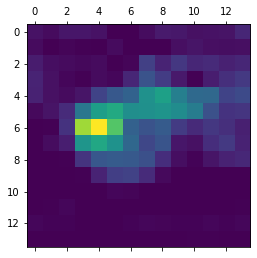

In [5]:
# set up Grad-CAM algorithm
african_elephant_output = model.output[:, 386]
last_conv_layer         = model.get_layer('block5_conv3')

# extract gradients
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# each entry = mean intensity of the gradients in a feature
pooled_grads = K.mean(grads, axis=(0,1,2))

# given an image, compute pooled_grads and extract last-layer outputs
# initiate the function defined above
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# apply the function to our image
pooled_grads_value, conv_layer_output_value = iterate([x])

# multiply each feature by how important it is
for i in range(512): # last layer has 512 features
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
# feature-wise mean = heatmap of the class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

# plot heatmap
%matplotlib inline
import matplotlib.pyplot as plt

heatmap  = np.maximum(heatmap, 0) # return an array
heatmap /= np.max(heatmap)        # return a value
plt.matshow(heatmap)

In [6]:
# superimpose heatmap to the original image
import cv2

# load original image
img     = cv2.imread(img_path)
# resize heatmap to the original image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# convert heatmap to RGB
heatmap = np.uint8(255*heatmap)
# apply heatmap to original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# generate superimposed image with a heathmap intensity factor of 0.5
superimposed_img = 0.5 * heatmap + img
# save the superimposed image to disk
cv2.imwrite('C:\\Users\\Carol\\Desktop\\elephant_cam.jpg', superimposed_img)

True